In [2]:
# This Notebook takes all RNA sequence , encode it using one-hot encoding and uses y column to predict if there is modification present or not.and
# This notebook does not tell what type of RNA modification it is and where is modification location. 
#Import All Libraries Here
import pandas as pd
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score ,  roc_curve, auc , classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import xgboost as xgb 

from imblearn.over_sampling import SMOTE 

In [3]:
#Read X Varaibles and Y Varaibles
train_rna_x_varaibles =  pd.read_csv("../data/train_in.csv" , header=None , skiprows=1)
train_rna_y_varaibles =  pd.read_csv("../data/train_out.csv"  , header=None , skiprows=1)

x_test_raw =  pd.read_csv("../data/test_in.csv" , header=None , skiprows=1)
y_test_raw =  pd.read_csv("../data/test_out.csv"  , header=None , skiprows=1)


In [4]:
# Encode using one-hot encoding 
def apply_one_hot_encode(sequence):
    nucleotides = ['C', 'A', 'T', 'G']
    one_hot = []
    for nucleotide in sequence:
        # For G - [0,0,1,0]
        if nucleotide == 'N': # N is not application , used for empty values.
            hot = [0,0,0,0]
        else:
            hot = [0 if nucleotide != nt else 1 for nt in nucleotides]

        one_hot.append(hot)
    return np.array(one_hot).flatten()
    # Apply flatten to make feature 2 Dimensional as Logistic Regression only support 2D matrix as features.

x_encoded= train_rna_x_varaibles.apply(apply_one_hot_encode ,axis=1)
x_encoded.head(3)

0    [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, ...
1    [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, ...
2    [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, ...
dtype: object

In [5]:
# Construct Y Variable - Logic - Sum Each Column if result is 1 then its modified else 0
# This function will help classfy into two categories 1, 0 
# 1 - RNA modification is present 
# 0 - RNA modification is not Present 
def sum_each_column_value(row):
    sum = 0
    for e in row :
        sum += e
    return sum
y_encoded = train_rna_y_varaibles.apply(sum_each_column_value , axis=1)
y_encoded.head(3)

0    1.0
1    1.0
2    1.0
dtype: float64

In [6]:
y_encoded.drop(y_encoded[(y_encoded >1)].index, inplace=True)  # Drop Rows where value is > 1
x_encoded = x_encoded.iloc[5:] # Dropping 5 rows to make shape similar to X
print('Shape of Y' ,y_encoded.shape)
print('Shape of X' ,x_encoded.shape)

# Check Distribution of Y Categories
y_encoded.value_counts()

Shape of Y (304656,)
Shape of X (304656,)


1.0    152448
0.0    152208
dtype: int64

# -------------------------------- Logistic Regression  ----------------------------------------

In [7]:
#Train Model using Logistic Regression
x_train= x_encoded.to_list()
y_train = y_encoded.to_list()

logreg = LogisticRegression(max_iter=300)
logreg.fit(x_train, y_train)

LogisticRegression(max_iter=300)

In [8]:
# Calculate Accuracy of Model 

x_test = x_test_raw.apply(apply_one_hot_encode, axis=1).to_list()
y_test = y_test_raw.apply(sum_each_column_value , axis=1).to_list()


y_pred = logreg.predict(x_test)

# Calculate the accuracy score of the logistic regression model
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy of logistic regression model: {:.2f}".format(accuracy))

Accuracy of logistic regression model: 0.66


Confusion Matrix


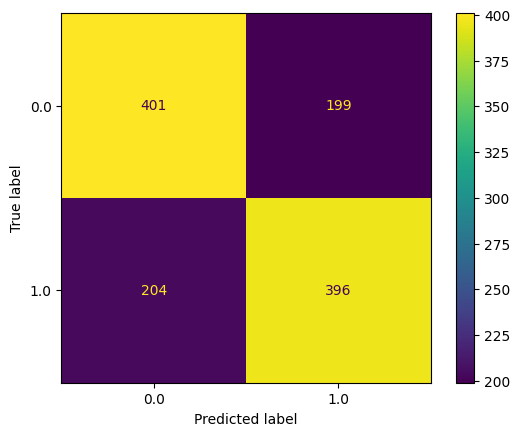

In [9]:
#Plot Confusion Matrix
print('Confusion Matrix')
cm = confusion_matrix(y_test, y_pred, labels=logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=logreg.classes_)
disp.plot()

# ---------------------------XGBoost Model Training ----------------------------------

In [10]:
# XGBoost Classification 
#Train Model using XGBoost Model
x_train= x_encoded.to_list()
y_train = y_encoded.to_list()


xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(x_train , y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Accuracy for XGBoost Model :  0.73


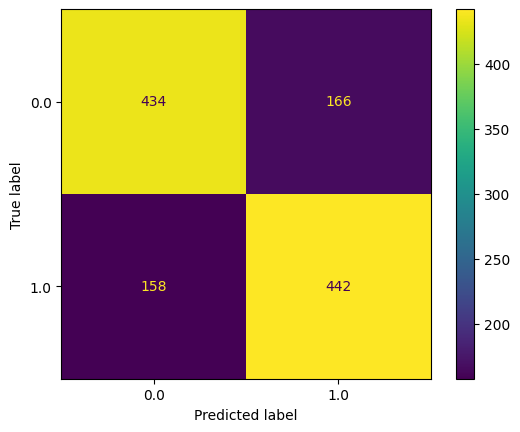

In [11]:
# XGBoost Accuracy and Confusion Matrix

y_pred_xgb = xgb_classifier.predict(x_test)
print("Accuracy for XGBoost Model : " , accuracy_score(y_test , y_pred_xgb))

#plot confusion matrix 
cm = confusion_matrix(y_test, y_pred_xgb, labels=logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=logreg.classes_)
disp.plot()


# ---------------------------------------- SVM Model ------------------------------------------

In [12]:
from sklearn import svm
from sklearn import metrics

# clf = svm.SVC()
# clf.fit(x_train , y_train)

#y_pred_svm = clf.predict(x_test)
#print("Accuraycy : " , metrics.accuracy_score(y_test , y_pred_svm))


# -------------------- Deploy Model using Heroku ---------------------------------

In [13]:
import pickle

##dump the model into a file
with open("model.bin", 'wb') as f_out:
    pickle.dump(xgb_classifier, f_out) # write final_model in .bin file
    f_out.close()  # close the file 
    print("Exported Model Successfully")  

Exported Model Successfully


In [17]:
x_train[0].shape

(4004,)